# Homework 5
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 2nd, 2018 at 11:00am

**Instructions:**

- Upload your final answers in a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

Name: Christopher Hase

In [103]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Problem 1: Optimization (contd)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Simulated Annealing 
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our loss function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

In [3]:
# function to compute loss
def loss(x, y, lam1, lam2):
    return 0.000045 * lam2**2 * y - 0.000098 * lam1**2 * x + 0.003926 * lam1 * x * np.exp((-0.1) * (lam1**2 + lam2**2))

In [6]:
# read in and manipulate data
hw3_data = pd.read_csv('HW3_data.csv', header = None)
hw3_data = hw3_data.transpose()
hw3_data.columns = ['x', 'y']

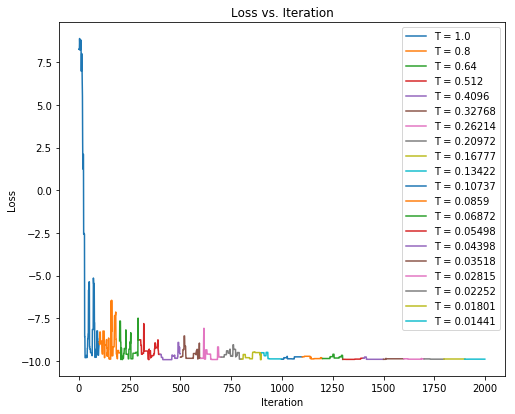

Final lambda 1: 2.05036151001
Final lambda 2: -0.00259829454933
Final loss:-9.93406470188


In [300]:
np.random.seed(10)

stage_length = 100 # number of iterations at each stage
num_iter = stage_length * 1000 # total number of iterations
T = 1 # initial temperature
lam1 = -5 # initial lambda 1
lam2 = 0 # initial lambda 2

loss_vec = np.zeros(num_iter)
temps = []
stage_iter = 0
for i in range(num_iter):
    current_loss = np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2)) # loss at lambda solution
    loss_vec[i] = current_loss
    
    # draw from bivariate normal centered at current lambda solution to get potential new solution
    lam1_neighbor, lam2_neighbor = np.random.multivariate_normal([lam1, lam2], np.identity(2))
    neighbor_loss = np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1_neighbor, lam2_neighbor)) # loss at potential new solution
    
    if neighbor_loss < current_loss: # condition for changing solution
        lam1 = lam1_neighbor
        lam2 = lam2_neighbor
    
    else: # change solution with some probability
        acceptance_prob = np.exp(-(neighbor_loss - current_loss)/T)
        draw = np.random.uniform()
        if acceptance_prob > draw:
            lam1 = lam1_neighbor
            lam2 = lam2_neighbor
    
    stage_iter += 1
    if stage_iter == stage_length: # condition for lowering temperature for next stage
        stage_iter = 0
        temps.append(T)
        T *= 0.8

 # plot losses vs. iterations for first 15 temps
plt.figure(figsize=(8, 6.5))
for i in range(20):
    plt.plot(np.arange(i*100, i*100 + 100), loss_vec[i*100:(i*100 + 100)])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.legend(loc = 'upper right',\
           labels = ['T = ' + str(np.around(np.array(temps[:20]), 5)[i]) for i in range(len(np.around(np.array(temps[:20]), 5)))])
plt.show()

print('Final lambda 1: ' + str(lam1))
print('Final lambda 2: ' + str(lam2))
print('Final loss:' + str(np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2))))

When using simulated annealing, the optimal solution for $\lambda_1,\lambda_2$ is approximately achieved even with the starting values being $\lambda_1=-5$ and $\lambda_2=0$. When using gradient descent and stochastic gradient descent in HW4, the final values for $\lambda_1$ and $\lambda_2$ were $\lambda_1=-5.363$ and $\lambda_2=0$ when the starting values were $\lambda_1=-5$ and $\lambda_2=0$, which is not the optimal solution.

The loss decreases and the loss oscillations get smaller as the temperature decreases and the number of iterations increases. The oscillation pattern is similar to what we see when we use Markov Chains to obtain the parameters of the stationary distribution. This makes sense since in both cases, randomness and prior parameter values are used to obtain new parameter values when moving towards some optimal solution.

## Problem 2: A Tired Salesman

In the famous traveling salesman problem, the quality of the solution can be measured in 
different ways, beyond finding the shortest path.  For example, the total time of travel may also be important, and may depend on the means of transportation that connect pairs of 
cities.  Consider a random distribution of $N$ points on a plane representing the cities 
that must be visited by the traveling salesman.  Each point is an (x,y) coordinate where both x and y are integers in the range [1, 50). Assign a value $s_i$ where $i\in [1,\dots,N]$ to each city that represents its size measured by population.  Let $\forall s_i, \  s_i \in [1, 10)$.  If two cities are farther away from each other than a **distance threshold of 10** and both have populations greater than a **population threshold of 5** assume there is a flight connection between them.  In all other cases assume that our poor salesman would have to drive between cities. Flying is faster than driving by a factor of 10. 

1. Use Simulated Annealing to find solutions to the traveling salesman problem for 
$N=100$, optimizing the travel path for the total distance travelled (but keeping track 
of the time of travel). 

2. Now redo the problem by optimizing the the path for the total time of travel (but keeping track of the distance traveled). Are the two solutions similar or different? 

3. How do your results change if the population and distance thresholds for the existence of a flight between two cities are altered?


In [352]:
# given a traveling order and coordinates, compute total distance traveled
def compute_total_distance(order, x, y):
    dist = 0
    for i in range(len(order)-1):
        dist += np.sqrt((x[order[i]] - x[order[i+1]])**2 + (y[order[i]] - y[order[i+1]])**2)
    return dist


# given a traveling order, coordinates, and population sizes, compute total time traveled
def compute_total_time(order, x, y, pops, pop_thresh, dist_thresh):
    time = 0
    for i in range(len(order)-1):
        current_trip_time = np.sqrt((x[order[i]] - x[order[i+1]])**2 + (y[order[i]] - y[order[i+1]])**2)
        
        if pops[order[i]] > pop_thresh and pops[order[i+1]] > pop_thresh and current_trip_time > dist_thresh:
            current_trip_time /= 10
            
        time += current_trip_time
        
    return time


# function that comes up with optimal travel order
def optimize_travel(order, x, y, pops, optimize_for, stage_length, num_iter, T, T_multiplier, pop_thresh, dist_thresh):
    print('Total distance traveled based on INITIAL ordering: ' + str(compute_total_distance(order, x, y)))
    print('Total time of travel based on INITIAL ordering: ' + str(compute_total_time(order, x, y, pops, pop_thresh, dist_thresh)))

    stage_iter = 0
    for i in range(num_iter):
        current_dist = compute_total_distance(order, x, y) # distance traveled based on current ordering
        current_time = compute_total_time(order, x, y, pops, pop_thresh, dist_thresh) # time of travel based on current ordering
    
        # flip random subsequence 
        neighbor_order = order.copy()
        start = np.random.choice(np.arange(1 ,len(order) - 1), 1)[0] # keep starting and ending point fixed; returning to same location
        end = np.random.choice(np.arange(start, len(order) - 1), 1)[0]
        reversed_subsequence = np.flip(neighbor_order[start:end], axis = 0)
        neighbor_order[start:end] = reversed_subsequence
        
        if optimize_for == 'distance':
            neighbor_dist = compute_total_distance(neighbor_order, x, y) # distance traveled based on potential new ordering

            if neighbor_dist < current_dist: # condition for changing ordering
                order = neighbor_order.copy()

            else: # change ordering with some probability
                acceptance_prob = np.exp(-(neighbor_dist - current_dist)/T)
                draw = np.random.uniform()
                if acceptance_prob > draw:
                    order = neighbor_order.copy()
                    
        elif optimize_for == 'time':
            neighbor_time = compute_total_time(neighbor_order, x, y, pops, pop_thresh, dist_thresh) # distance traveled based on potential new ordering
    
            if neighbor_time < current_time: # condition for changing ordering
                order = neighbor_order.copy()
                
            else: # change ordering with some probability
                acceptance_prob = np.exp(-(neighbor_time - current_time)/T)
                draw = np.random.uniform()
                if acceptance_prob > draw:
                    order = neighbor_order.copy()
    
        stage_iter += 1
        if stage_iter == stage_length: # condition for lowering temperature for next stage
            stage_iter = 0
            T *= T_multiplier
            
    tot_dist = compute_total_distance(order, x, y)
    tot_time = compute_total_time(order, x, y, pops, pop_thresh, dist_thresh)

    print()
    print('Total distance traveled based on FINAL ordering: ' + str(tot_dist))
    print('Total time of travel based on FINAL ordering: ' + str(tot_time))
    
    return tot_dist, tot_time, None

Part 1

In [373]:
np.random.seed(1)

N = 100
x = np.random.uniform(1, 50, N) # x coords
y = np.random.uniform(1, 50, N) # y coords
pops = np.random.uniform(1, 10, N) # population sizes

order = list(np.random.choice(np.arange(N), N, replace = False)) # initial travel ordering
order.append(order[0]) # end at starting point
order = np.array(order)

optimize_for = 'distance'
stage_length = 50 # number of iterations at each stage
num_iter = stage_length * 1000 # total number of iterations
T = 100 # initial temperature
T_multiplier = 0.99 # for cooling schedule
pop_thresh = 5 # for determining if flight
dist_thresh = 10 # for determining if flight

optimize_travel(order, x, y, pops, optimize_for, stage_length, num_iter, T, T_multiplier, pop_thresh, dist_thresh)[2]

Total distance traveled based on INITIAL ordering: 2536.02676191
Total time of travel based on INITIAL ordering: 1818.89168835

Total distance traveled based on FINAL ordering: 422.355666888
Total time of travel based on FINAL ordering: 410.19152602


Part 2

In [375]:
np.random.seed(1)

N = 100
x = np.random.uniform(1, 50, N) # x coords
y = np.random.uniform(1, 50, N) # y coords
pops = np.random.uniform(1, 10, N) # population sizes

order = list(np.random.choice(np.arange(N), N, replace = False)) # initial travel ordering
order.append(order[0]) # end at starting point
order = np.array(order)

optimize_for = 'time'
stage_length = 50 # number of iterations at each stage
num_iter = stage_length * 1000 # total number of iterations
T = 100 # initial temperature
T_multiplier = 0.99 # for cooling schedule
pop_thresh = 5 # for determining if flight
dist_thresh = 10 # for determining if flight

optimize_travel(order, x, y, pops, optimize_for, stage_length, num_iter, T, T_multiplier, pop_thresh, dist_thresh)[2]

Total distance traveled based on INITIAL ordering: 2536.02676191
Total time of travel based on INITIAL ordering: 1818.89168835

Total distance traveled based on FINAL ordering: 777.193154923
Total time of travel based on FINAL ordering: 271.509422175


The solutions are not the same. As we would expect, the solution from part 1 has a lower total distance traveled and the solution from part 2 has a lower time of travel.

Part 3

In [379]:
np.random.seed(1)

N = 100
x = np.random.uniform(1, 50, N) # x coords
y = np.random.uniform(1, 50, N) # y coords
pops = np.random.uniform(1, 10, N) # population sizes

order = list(np.random.choice(np.arange(N), N, replace = False)) # initial travel ordering
order.append(order[0]) # end at starting point
order = np.array(order)

optimize_for = 'time'
stage_length = 50 # number of iterations at each stage
num_iter = stage_length * 1000 # total number of iterations
T_multiplier = 0.99 # for cooling schedule
pop_thresh_list = [2.5, 5, 7.5] # for determining if flight
dist_thresh_list = [5, 10, 15] # for determining if flight

results_time = np.zeros((3, 3, 2))
for i in range(len(pop_thresh_list)):
    for j in range(len(dist_thresh_list)):
            
        T = 100 # initial temperature
                
        print('Population threshold: ' + str(pop_thresh_list[i]) + ', distance threshold: ' + str(dist_thresh_list[j]) + ', optimizing for ' + optimize_for)
        tot_dist, tot_time = optimize_travel(order, x, y, pops, optimize_for, stage_length, num_iter, T, T_multiplier, pop_thresh_list[i], dist_thresh_list[j])[:2]
            
        results_time[i, j, 0] = tot_dist
        results_time[i, j, 1] = tot_time
                
        print()
        print()
        print()

Population threshold: 2.5, distance threshold: 5, optimizing for time
Total distance traveled based on INITIAL ordering: 2536.02676191
Total time of travel based on INITIAL ordering: 720.168980323

Total distance traveled based on FINAL ordering: 662.594157443
Total time of travel based on FINAL ordering: 113.972664418



Population threshold: 2.5, distance threshold: 10, optimizing for time
Total distance traveled based on INITIAL ordering: 2536.02676191
Total time of travel based on INITIAL ordering: 802.948768401

Total distance traveled based on FINAL ordering: 1006.03674351
Total time of travel based on FINAL ordering: 147.822163075



Population threshold: 2.5, distance threshold: 15, optimizing for time
Total distance traveled based on INITIAL ordering: 2536.02676191
Total time of travel based on INITIAL ordering: 962.866937293

Total distance traveled based on FINAL ordering: 1352.94772948
Total time of travel based on FINAL ordering: 186.583921146



Population threshold: 5, d

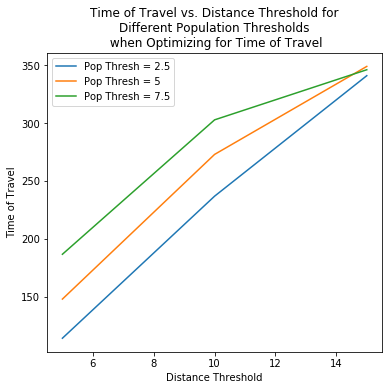

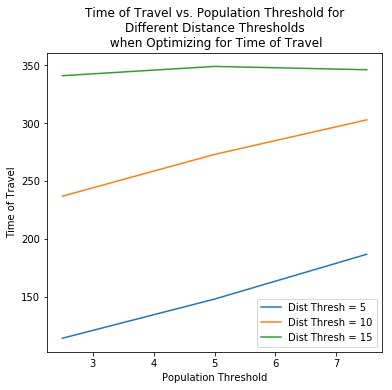

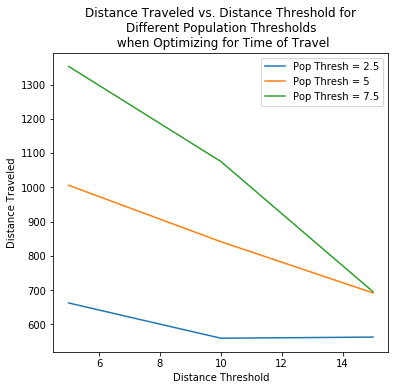

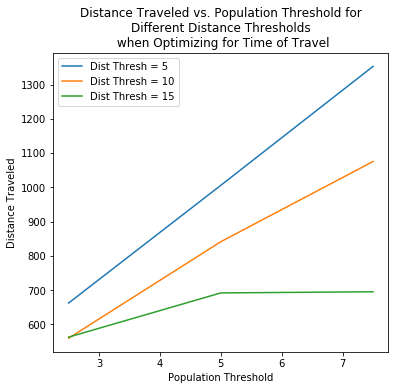

In [382]:
plt.figure(figsize=(6, 5.5))
plt.plot(dist_thresh_list, results_time[:, 0, 1])
plt.plot(dist_thresh_list, results_time[:, 1, 1])
plt.plot(dist_thresh_list, results_time[:, 2, 1])
plt.title('Time of Travel vs. Distance Threshold for\nDifferent Population Thresholds\n when Optimizing for Time of Travel')
plt.xlabel('Distance Threshold')
plt.ylabel('Time of Travel')
plt.legend(loc = 'upper left', labels = ['Pop Thresh = 2.5', 'Pop Thresh = 5', 'Pop Thresh = 7.5'])
plt.show()

plt.figure(figsize=(6, 5.5))
plt.plot(pop_thresh_list, results_time[0, :, 1])
plt.plot(pop_thresh_list, results_time[1, :, 1])
plt.plot(pop_thresh_list, results_time[2, :, 1])
plt.title('Time of Travel vs. Population Threshold for\nDifferent Distance Thresholds\n when Optimizing for Time of Travel')
plt.xlabel('Population Threshold')
plt.ylabel('Time of Travel')
plt.legend(loc = 'lower right', labels = ['Dist Thresh = 5', 'Dist Thresh = 10', 'Dist Thresh = 15'])
plt.show()

plt.figure(figsize=(6, 5.5))
plt.plot(dist_thresh_list, results_time[:, 0, 0])
plt.plot(dist_thresh_list, results_time[:, 1, 0])
plt.plot(dist_thresh_list, results_time[:, 2, 0])
plt.title('Distance Traveled vs. Distance Threshold for\nDifferent Population Thresholds\n when Optimizing for Time of Travel')
plt.xlabel('Distance Threshold')
plt.ylabel('Distance Traveled')
plt.legend(loc = 'upper right', labels = ['Pop Thresh = 2.5', 'Pop Thresh = 5', 'Pop Thresh = 7.5'])
plt.show()

plt.figure(figsize=(6, 5.5))
plt.plot(pop_thresh_list, results_time[0, :, 0])
plt.plot(pop_thresh_list, results_time[1, :, 0])
plt.plot(pop_thresh_list, results_time[2, :, 0])
plt.title('Distance Traveled vs. Population Threshold for\nDifferent Distance Thresholds\n when Optimizing for Time of Travel')
plt.xlabel('Population Threshold')
plt.ylabel('Distance Traveled')
plt.legend(loc = 'upper left', labels = ['Dist Thresh = 5', 'Dist Thresh = 10', 'Dist Thresh = 15'])
plt.show()

Note that all of the following results are associated with optimizing for time of travel.

Holding distance threshold constant, as population threshold increases, so does time of travel. Holding population threshold constant, as distance threshold increases, so does time of travel. Holding distance threshold constant, as population threshold increases, so does distance traveled. Holding population threshold constant, as distance threshold increases, distance traveled decreases.